In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,\
                             AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [2]:
df = pd.read_csv('../data/features_with_genres.csv')

# Free Lunch Analysis

Modeling on the entire dataset with no real thought to feature selection.

In [3]:
df['track_genre_top'].value_counts(normalize=True)

Folk             0.125094
Instrumental     0.125094
Pop              0.125094
International    0.125094
Experimental     0.124969
Rock             0.124969
Electronic       0.124969
Hip-Hop          0.124719
Name: track_genre_top, dtype: float64

**Interpretation:** The baseline accuracy is 12.5%

In [4]:
track_metadata = ['track_genre_top', 'track_title', 'artist_name']

X = df.drop(columns=track_metadata)
y = df['track_genre_top']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                   random_state=42)

In [5]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

## Random Forest Classifier

In [62]:
forest = RandomForestClassifier(max_depth = 3, n_estimators = 750,
                                random_state=42)
cross_val_score(forest, X_train, y_train, n_jobs=5)

array([0.42535446, 0.43703086, 0.4295246 , 0.41534612, 0.43786489])

In [63]:
forest.fit(X_train, y_train)
forest.score(X_test, y_test), forest.score(X_train, y_train)

(0.4242121060530265, 0.4482068390325271)

**Interpretation:** This model is overfit but not too badly.

## Gradient Boosting Classifier

In [53]:
gbm = GradientBoostingClassifier(min_samples_split = 10, subsample = .7,
                                 max_features = 'sqrt', n_iter_no_change = 5,
                                 n_estimators = 500, learning_rate = .0001,
                                 verbose=0)
cross_val_score(gbm, X_test, y_test)

array([0.49      , 0.485     , 0.4675    , 0.4525    , 0.45614035])

In [54]:
gbm.fit(X_train, y_train)
gbm.score(X_test, y_test), gbm.score(X_train, y_train)

(0.4822411205602801, 0.5451209341117598)

In [126]:
pd.DataFrame(gbm.feature_importances_,
             index=X_train.columns).sort_values(by=0, ascending=False)[:10]

,0
mfcc_mean_03,0.018655
spectral_bandwidth_median_01,0.018544
spectral_rolloff_median_01,0.018296
mfcc_median_03,0.018201
spectral_rolloff_mean_01,0.017159
spectral_centroid_median_01,0.017146
mfcc_median_01,0.016058
spectral_bandwidth_mean_01,0.015332
mfcc_max_04,0.014835
spectral_centroid_mean_01,0.014701


**Interpretation:** The gradient boosting improved the score however it also resulted in a more overfit model. I would like to do a gridsearch on this one to see if I can reduce the overfitting.

In [29]:
ada = AdaBoostClassifier(n_estimators = 300, learning_rate=.01)
cross_val_score(ada, X_test, y_test)

array([0.41      , 0.445     , 0.38      , 0.3675    , 0.35087719])

In [30]:
ada.fit(X_train, y_train)
ada.score(X_test, y_test), ada.score(X_train, y_train)

(0.4227113556778389, 0.4398665554628857)

## Logistic Regression

In [81]:
lrcv = LogisticRegressionCV(max_iter = 1000)
lrcv.fit(X_train_sc, y_train)

/home/icculus/anaconda3/envs/audio_processing/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/icculus/anaconda3/envs/audio_processing/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

LogisticRegressionCV(max_iter=1000)

In [68]:
lrcv.score(X_test_sc, y_test), lrcv.score(X_train_sc, y_train)

(0.5767883941970986, 0.6662218515429524)

In [74]:
lrcv.C_

array([0.00599484, 0.00599484, 0.00599484, 0.00599484, 0.00599484,
       0.00599484, 0.00599484, 0.00599484])

**Interpretation:** I will use 0.00599484 as my regularization strength. The logistic regression did not converge and I believe this is because there are too many columns for the number of rows used in each cross validation fold.

In [43]:
lr = LogisticRegression(C = .00599484, max_iter = 1000)
cross_val_score(lr, X_train_sc, y_train)

array([0.57130942, 0.58381985, 0.57714762, 0.57964971, 0.57214345])

In [44]:
lr.fit(X_train_sc, y_train)
lr.score(X_test_sc, y_test), lr.score(X_train_sc, y_train)

(0.5767883941970986, 0.6662218515429524)

**Interpretation:** This model is overfit but it did a lot better than my tree based models. This suggests a linear relationship between frequency features and genre.

In [42]:
pd.DataFrame(lr.coef_, columns=X_train.columns)

,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,-0.025476,-0.040860,0.046156,-0.020667,0.013745,-0.042973,-0.029480,0.006136,-0.043726,-0.012364,...,0.001908,0.060594,0.026367,0.035498,-0.018625,-0.096307,-0.106073,-0.046290,-0.038620,-0.049738
1,-0.028519,0.025212,-0.014948,0.033314,0.029537,0.010640,0.011014,0.048996,-0.003017,-0.049361,...,-0.018302,0.080415,0.059661,0.021753,0.014725,0.110615,0.106609,0.004292,0.061645,0.105421
2,-0.000515,0.002466,0.009605,0.029150,0.016663,-0.028863,0.020518,0.007512,-0.017631,-0.015496,...,0.056307,-0.015243,0.025717,-0.033696,-0.032843,-0.029041,-0.052745,-0.002298,-0.031203,0.046943
3,-0.039642,-0.001999,0.001909,0.017456,-0.012945,-0.051661,0.024997,-0.014093,0.057557,0.042876,...,-0.037456,0.009253,0.040067,-0.087244,0.041155,-0.004572,-0.047306,-0.066815,-0.073214,0.062228
4,0.051651,0.022450,-0.009980,0.014735,0.004337,0.051394,-0.011206,-0.000238,0.023194,0.027762,...,0.034720,0.053814,0.046613,-0.010851,-0.099041,0.024798,0.031751,0.043926,0.003313,0.020369
5,-0.023276,-0.007128,-0.027687,0.019164,-0.010902,-0.020055,-0.008239,-0.038517,-0.078769,-0.032976,...,-0.131480,-0.139608,-0.177339,-0.013824,0.025777,-0.041964,-0.042816,0.148997,-0.058526,-0.099874
6,0.005609,-0.006871,-0.008739,-0.001487,-0.022034,0.051091,-0.027552,0.017025,0.034494,0.050623,...,0.071284,-0.007914,0.001182,0.010550,0.062617,-0.016564,-0.007123,-0.111132,0.112005,-0.023881
7,0.060169,0.006729,0.003683,-0.091664,-0.018399,0.030427,0.019948,-0.026821,0.027897,-0.011065,...,0.023019,-0.041311,-0.022269,0.077812,0.006237,0.053033,0.117703,0.029320,0.024600,-0.061468


## K Nearest Neighbors

In [22]:
knn = KNeighborsClassifier(p=2, n_neighbors=5)
cross_val_score(knn, X_train_sc, y_train)

array([0.48457048, 0.48457048, 0.46788991, 0.44036697, 0.46455379])

In [23]:
knn.fit(X_train_sc, y_train)
knn.score(X_test_sc, y_test), knn.score(X_train_sc, y_train)

(0.46823411705852924, 0.6513761467889908)

# Principal Component Analysis

In [6]:
pca = PCA()
pca.fit(X_train_sc)

PCA()

In [7]:
X_train.shape

(5995, 519)

In [8]:
len(X_train)**.5

77.42738533619743

In [9]:
sum([round(val, 5) for val in pca.explained_variance_ratio_][:77])

0.7925800000000004

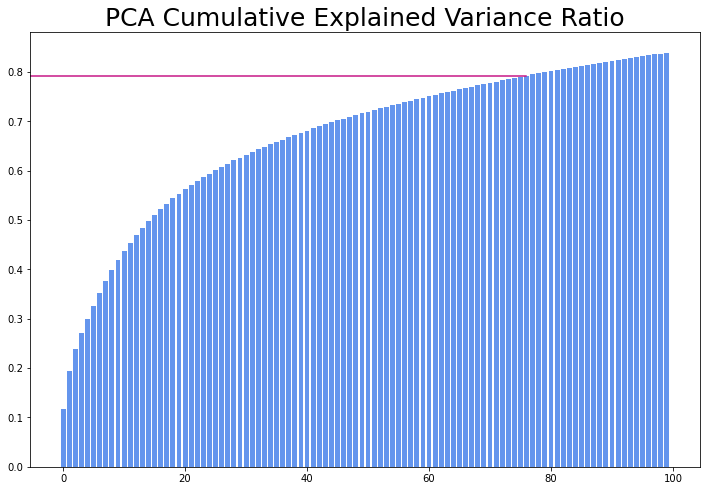

In [13]:
plt.figure(figsize=(12,8))
plt.bar(x=range(100), height=np.cumsum(pca.explained_variance_ratio_)[:100],
        color = 'cornflowerblue')
plt.axhline(y=0.792, xmax=.74, color='mediumvioletred')

plt.title('PCA Cumulative Explained Variance Ratio', size = 25)
plt.savefig('../images/pca_cumulative_explained_variance_ratio.png');

**Interpretation:** As a rule of thumb I like to try reducing features down to square root of the length of my data which in this case is 77. ~80% of the variability is explained by the first 77 principal components.

In [111]:
pca = PCA(77)
pca.fit(X_train_sc)

X_train_pca = pd.DataFrame(pca.transform(X_train_sc))
X_test_pca = pd.DataFrame(pca.transform(X_test_sc))

In [112]:
lr = LogisticRegression(C = .00599484, max_iter = 1000)
cross_val_score(lr, X_train_pca, y_train)

array([0.52543786, 0.55629691, 0.5471226 , 0.54295246, 0.53127606])

In [113]:
lr.fit(X_train_pca, y_train)
lr.score(X_test_pca, y_test), lr.score(X_train_pca, y_train)

(0.5387693846923461, 0.5694745621351126)

**Interpretation:** This logistic regression has an increase in bias but a greater reduction in overfitting. It is ~5% less accurate on the test set and 10% less accurate on the training set.

## Chroma Cens Analysis
Instead of putting all of the features into my models I investigate specific ones to judge which are most important.

**Audio Features**
- 'chroma_cens
- 'chroma_cqt'
- 'chroma_stft'
- 'mfcc'
- 'rmse'
- 'spectral_bandwidth'
- 'spectral_centroid'
- 'spectral_contrast'
- 'spectral_rolloff'
- 'tonnetz'
- 'zcr'

In [16]:
chroma_cens_cols = [col for col in df.columns if 'chroma_cens' in col]
tonnetz_cols = [col for col in df.columns if 'tonnetz' in col]
spectral_bdwth_cols = [col for col in df.columns if 'spectral_bandwidth' in col]
mfcc_cols = [col for col in df.columns if 'mfcc' in col]

In [135]:
X = df[chroma_cens_cols]
y = df['track_genre_top']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                   random_state=42)

In [136]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [148]:
lr = LogisticRegression(C = .00599484, max_iter = 1000)
lr.fit(X_train_sc, y_train)
lr.score(X_test_sc, y_test), lr.score(X_train_sc, y_train)

(0.27963981990995496, 0.30825688073394497)

**Interpretation:** While this model is better than the baseline it does not do nearly as well as the logistic regression on the full dataset. These summary statistics on the chroma energy normalized chromagram probably aren't the best features.

In [150]:
pca = PCA()
pca.fit(X_train_sc)

PCA()

In [139]:
len(X_train.columns)

84

In [144]:
sum([round(val, 5) for val in pca.explained_variance_ratio_][:42])

0.9510099999999997

**Interpretation:** 95% of the variability of the data is captured in the first 42 principal components.

In [153]:
pca = PCA(42)
pca.fit(X_train_sc)

PCA(n_components=42)

In [154]:
X_train_pca = pd.DataFrame(pca.transform(X_train_sc))
X_test_pca = pd.DataFrame(pca.transform(X_test_sc))

In [155]:
lr = LogisticRegression(C = .00599484, max_iter = 1000)
lr.fit(X_train_pca, y_train)
lr.score(X_test_pca, y_test), lr.score(X_train_pca, y_train)

(0.2726363181590795, 0.28990825688073396)

**Interpretation:** Principal component analysis helped to reduce overfitting in this model but not by much.

## Tonnetz Analysis

In [189]:
X = df[tonnetz_cols]
y = df['track_genre_top']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                   random_state=42)

In [159]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [164]:
lr = LogisticRegression(C = .00599484, max_iter = 1000)
lr.fit(X_train_sc, y_train)
lr.score(X_test_sc, y_test), lr.score(X_train_sc, y_train)

(0.27913956978489246, 0.31075896580483736)

**Interpretation:** While this model is better than the baseline it does not do nearly as well as the logistic regression on the full dataset. These summary statistics on the tonnetz probably aren't the best features.

In [165]:
pca = PCA()
pca.fit(X_train_sc)

PCA()

In [166]:
len(X_train.columns)

42

In [168]:
sum([round(val, 5) for val in pca.explained_variance_ratio_][:21])

0.9288200000000001

**Interpretation:** 93% of the variability of the data is captured in the first 21 principal components.

In [170]:
pca = PCA(21)
pca.fit(X_train_sc)

PCA(n_components=21)

In [171]:
X_train_pca = pd.DataFrame(pca.transform(X_train_sc))
X_test_pca = pd.DataFrame(pca.transform(X_test_sc))

In [173]:
lr = LogisticRegression(C = .00599484, max_iter = 1000)
lr.fit(X_train_pca, y_train)
lr.score(X_test_pca, y_test), lr.score(X_train_pca, y_train)

(0.26263131565782893, 0.28607172643869894)

**Interpretation:** Principal component analysis helped to reduce overfitting in this model but not by much.

## MFCC Analysis

In [30]:
X = df[mfcc_cols]
y = df['track_genre_top']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                   random_state=42)

In [31]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [32]:
lr = LogisticRegression(C = .00599484, max_iter = 1000)
lr.fit(X_train_sc, y_train)
lr.score(X_test_sc, y_test), lr.score(X_train_sc, y_train)

(0.5222611305652827, 0.538115095913261)

In [33]:
preds = lr.predict(X_test_sc)
labels = sorted(list(set(y_test.values)))
pd.DataFrame(confusion_matrix(y_test, preds),
             columns=labels,
             index=labels)

,Electronic,Experimental,Folk,Hip-Hop,Instrumental,International,Pop,Rock
Electronic,124,12,3,53,18,16,16,8
Experimental,32,66,16,19,50,25,14,28
Folk,2,8,167,4,19,21,18,11
Hip-Hop,30,6,4,164,5,19,15,6
Instrumental,9,22,18,8,156,9,10,18
International,18,10,25,31,9,136,9,12
Pop,25,15,26,26,22,22,65,49
Rock,4,13,16,10,9,13,19,166


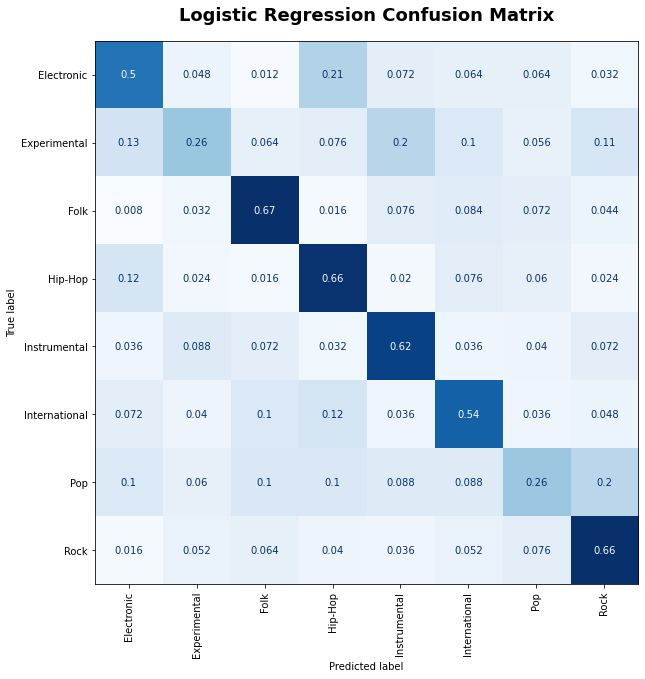

In [68]:
# https://panjeh.medium.com/figure-size-plot-confusion-matrix-in-scikit-learn-2c66f3a69d81

fig, ax = plt.subplots(figsize=(10,10))

plot_confusion_matrix(lr, X_test_sc, y_test,
                      display_labels=labels, cmap='Blues',
                      ax=ax, colorbar=False, xticks_rotation='vertical',
                      normalize='true')
ax.set_title('Logistic Regression Confusion Matrix',
             size=18, pad=20, weight='bold')
plt.savefig('../images/lr_confusion_matrix.png');

**Interpretation:** The accuracy here is pretty close to the accuracy on the entire dataset! The accuracy of the logistic regression with all of the features was 57.7 on the test set and 66.6 on the training set. Not only is the accuracy close but overfitting has been reduced by a lot.

In [21]:
pca = PCA()
pca.fit(X_train_sc)

PCA()

In [22]:
len(X_train.columns)

140

In [23]:
sum([round(val, 5) for val in pca.explained_variance_ratio_][:77])

0.97095

In [24]:
pca = PCA(77)
pca.fit(X_train_sc)

PCA(n_components=77)

In [25]:
X_train_pca = pd.DataFrame(pca.transform(X_train_sc))
X_test_pca = pd.DataFrame(pca.transform(X_test_sc))

In [26]:
lr = LogisticRegression(C = .00599484, max_iter = 1000)
cross_val_score(lr, X_train_sc, y_train)

array([0.50708924, 0.52126772, 0.49958299, 0.49791493, 0.49958299])

In [27]:
lr = LogisticRegression(C = .00599484, max_iter = 1000)
lr.fit(X_train_pca, y_train)
lr.score(X_test_pca, y_test), lr.score(X_train_pca, y_train)

(0.5107553776888444, 0.5286071726438699)

In [28]:
preds = lr.predict(X_test_pca)
pd.DataFrame(confusion_matrix(y_test, preds),
             columns=labels,
             index=labels)

,Electronic,Experimental,Folk,Hip-Hop,Instrumental,International,Pop,Rock
Electronic,122,12,3,53,19,15,16,10
Experimental,29,62,17,20,54,26,16,26
Folk,4,9,164,4,20,22,17,10
Hip-Hop,34,8,4,158,4,21,13,7
Instrumental,10,21,20,10,155,8,9,17
International,18,12,27,32,9,132,9,11
Pop,20,17,26,31,20,24,63,49
Rock,5,10,16,11,13,12,18,165


In [188]:
gbm = GradientBoostingClassifier(min_samples_split = 10, subsample = 1,
                                 max_features = 'sqrt', n_iter_no_change = 5,
                                 n_estimators = 500, learning_rate = .0001,
                                 tol = .0001, verbose=1)
gbm.fit(X_train, y_train)
gbm.score(X_test, y_test), gbm.score(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           2.0794            1.12m
         2           2.0793            1.11m
         3           2.0792            1.09m
         4           2.0791            1.09m
         5           2.0790            1.08m
         6           2.0789            1.08m
         7           2.0788            1.09m
         8           2.0787            1.09m
         9           2.0786            1.10m
        10           2.0785            1.09m
        20           2.0777            1.06m
        30           2.0768            1.03m
        40           2.0759            1.01m
        50           2.0750           58.87s
        60           2.0742           57.45s
        70           2.0733           56.31s
        80           2.0724           55.04s
        90           2.0715           53.74s
       100           2.0707           52.43s
       200           2.0621           39.09s
       300           2.0536           26.02s
       40

(0.455, 0.5151666666666667)

In [189]:
gbm = GradientBoostingClassifier(min_samples_split = 10, subsample = 1,
                                 max_features = 'sqrt', n_iter_no_change = 5,
                                 n_estimators = 500, learning_rate = .0001,
                                 tol = .0001, verbose=1)
gbm.fit(X_train_pca, y_train)
gbm.score(X_test_pca, y_test), gbm.score(X_train_pca, y_train)

      Iter       Train Loss   Remaining Time 
         1           2.0794           45.01s
         2           2.0793           44.64s
         3           2.0793           45.51s
         4           2.0793           45.18s
         5           2.0792           44.79s
         6           2.0792           44.74s
         7           2.0791           44.63s
         8           2.0791           44.38s
         9           2.0790           44.31s
        10           2.0790           44.11s
        20           2.0785           42.81s
        30           2.0780           41.73s
        40           2.0775           40.83s
        50           2.0770           39.80s
        60           2.0764           38.78s
        70           2.0760           37.80s
        80           2.0755           36.87s
        90           2.0750           35.96s
       100           2.0745           35.03s
       200           2.0698           26.13s
       300           2.0650           17.43s
       40

(0.4445, 0.5128333333333334)

In [195]:
knn = KNeighborsClassifier(p=1)
cross_val_score(knn, X_train_sc, y_train)

array([0.49040867, 0.49791493, 0.48040033, 0.48623853, 0.49374479])

In [196]:
knn.fit(X_train_sc, y_train)
knn.score(X_test_sc, y_test), knn.score(X_train_sc, y_train)

(0.49874937468734365, 0.6615512927439533)

In [197]:
knn.fit(X_train_pca, y_train)
knn.score(X_test_pca, y_test), knn.score(X_train_pca, y_train)

(0.4897448724362181, 0.6555462885738115)

**Interpretation:** Knn is quite over fit and I shan't pursue it at this time.